In [2]:
import numpy as np

# Set the seed for reproducibility (optional)
np.random.seed(42)

# Length of the vectors
n = 100

# Generate the predictor X
x = np.random.randn(100, 1)

# Generate the noise vector eps
eps = np.random.randn(100, 1)

In [3]:
betas = [5, -10, 3, 14]

y = betas[0] + betas[1] * x + betas[2] * (x**2) + betas[3] * (x**3) + eps

## Best subset selection

In [4]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

poly = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly.fit_transform(x)

cols = ['x'+str(i) for i in range(1, 11)] + ['y']
X_df = pd.DataFrame(np.concatenate((X_poly,y), axis=1), columns=cols)
X_df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.496714,0.246725,0.122552,0.060873,0.030237,0.015019,7.460119e-03,3.705547e-03,1.840597e-03,9.142508e-04,1.073387
1,-0.138264,0.019117,-0.002643,0.000365,-0.000051,0.000007,-9.659851e-07,1.335613e-07,-1.846675e-08,2.553293e-09,5.982344
2,0.647689,0.419500,0.271706,0.175981,0.113981,0.073824,4.781493e-02,3.096918e-02,2.005838e-02,1.299158e-02,3.242780
3,1.523030,2.319620,3.532850,5.380637,8.194870,12.481032,1.900898e+01,2.895125e+01,4.409362e+01,6.715590e+01,45.386190
4,-0.234153,0.054828,-0.012838,0.003006,-0.000704,0.000165,-3.859250e-05,9.036565e-06,-2.115942e-06,4.954550e-07,7.164998


In [5]:
import statsmodels.api as sm
from itertools import combinations
from tqdm import tqdm

def process_linear_model(subset, data, response):
    x_train = sm.add_constant(data[subset])
    model = sm.OLS(response, x_train).fit()
    train_RSS = model.ssr
    return (model, train_RSS)

def find_best_subset(data, response, max_features, operation):
    best_sub_list = []
    best_model = []
    num_of_features = []
    
    for k in tqdm(range(1, max_features+1)):
        best_rss = np.inf
        best_kth_model = None
        
        subsets = combinations(data.columns, k)
        
        for subset in subsets:
            result = process_linear_model(list(subset), data, response)
            if result[1] < best_rss:
                best_rss = result[1]
                best_subset = list(subset)
                best_kth_model = result[0]
                
        num_of_features.append(k)
        best_sub_list.append(best_subset)
        best_model.append(best_kth_model)
            
    results = pd.DataFrame({'sub': best_sub_list, 'model': best_model})
    results.to_pickle(f'{operation}.pkl')
    return results

In [6]:
X = X_df.drop(['y'], axis=1)
y = X_df.y

bestsub_results = find_best_subset(X, y, 10, 'poly_bestsub')

100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


In [7]:
# best subset selection results
bestsub_results

,sub,model
0,[x3],<statsmodels.regression.linear_model.Regressio...
1,"[x1, x3]",<statsmodels.regression.linear_model.Regressio...
2,"[x1, x2, x3]",<statsmodels.regression.linear_model.Regressio...
3,"[x1, x2, x3, x10]",<statsmodels.regression.linear_model.Regressio...
4,"[x1, x2, x3, x7, x9]",<statsmodels.regression.linear_model.Regressio...
5,"[x1, x2, x3, x6, x8, x10]",<statsmodels.regression.linear_model.Regressio...
6,"[x1, x2, x3, x4, x6, x8, x10]",<statsmodels.regression.linear_model.Regressio...
7,"[x1, x2, x3, x4, x5, x6, x8, x10]",<statsmodels.regression.linear_model.Regressio...
8,"[x1, x2, x3, x4, x5, x6, x7, x8, x10]",<statsmodels.regression.linear_model.Regressio...
9,"[x1, x2, x3, x4, x5, x6, x7, x8, x9, x10]",<statsmodels.regression.linear_model.Regressio...


In [8]:
aic = [bestsub_results.model[i].aic for i in range(0, len(bestsub_results.model))]
bic = [bestsub_results.model[i].bic for i in range(0, len(bestsub_results.model))]
r2_adj = [bestsub_results.model[i].rsquared_adj for i in range(0, len(bestsub_results.model))]
rss = [bestsub_results.model[i].ssr for i in range(0, len(bestsub_results.model))]

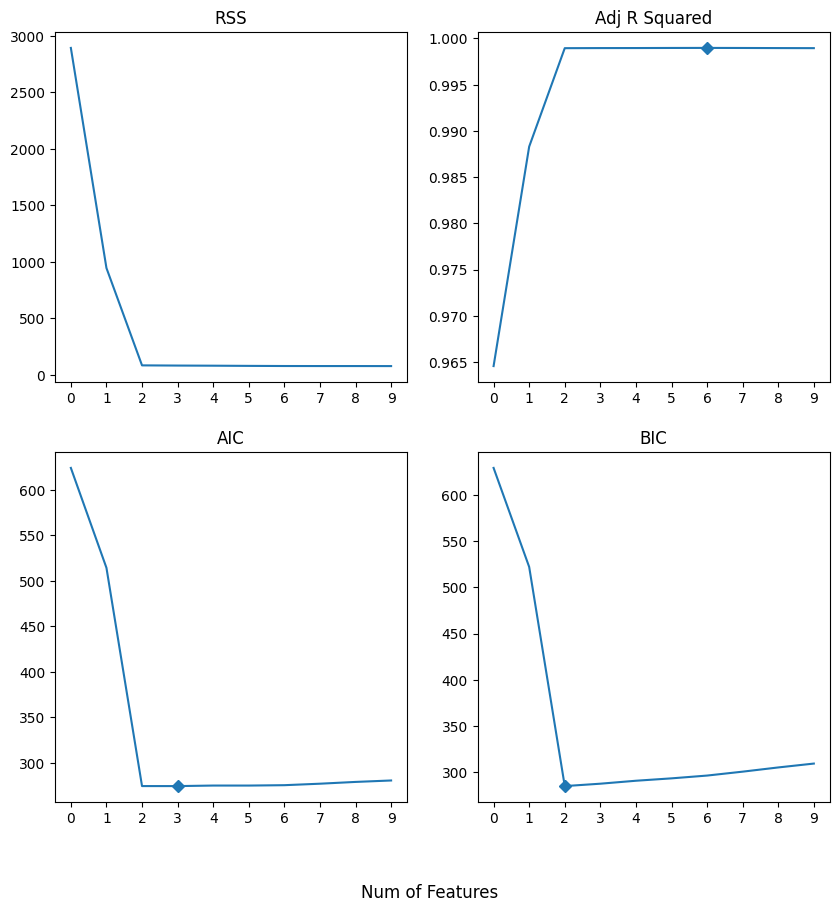

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, sharex=False, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.supxlabel('Num of Features')

axes[0, 0].plot(rss)
axes[0, 0].set_title('RSS')
axes[0, 0].set_xticks(np.arange(0, 10, 1))

axes[0, 1].plot(r2_adj, markevery=[np.argmax(r2_adj)], marker='D')
axes[0, 1].set_title('Adj R Squared')
axes[0, 1].set_xticks(np.arange(0, 10, 1))

axes[1, 0].plot(aic, markevery=[np.argmin(aic)], marker='D')
axes[1, 0].set_title('AIC')
axes[1, 0].set_xticks(np.arange(0, 10, 1))

axes[1, 1].plot(bic, markevery=[np.argmin(bic)], marker='D')
axes[1, 1].set_title('BIC')
axes[1, 1].set_xticks(np.arange(0, 10, 1))

The best model obtained:

According to:

- BIC => 2-variable model [x1, x3]
- Adjusted R2 => 6-variable model [x1, x2, x3, x6, x8, x10]
- AIC => 3-variable model [x1, x2, x3]

In [10]:
# Coefficient estimates for best model obtained acc.to BIC
bestsub_results.model[1].params

const     7.211349
x1       -8.324242
x3       12.786700
dtype: float64

In [11]:
# Coefficient estimates for best model obtained acc.to Adjusted R2
bestsub_results.model[5].params

const     4.729329
x1      -10.047974
x2        3.780139
x3       13.999950
x6       -0.381452
x8        0.143770
x10      -0.013174
dtype: float64

In [12]:
# Coefficient estimates for best model obtained acc.to AIC
bestsub_results.model[2].params

const     4.847927
x1      -10.135707
x2        3.206938
x3       14.028366
dtype: float64

## Forward stepwise

In [13]:
def forward_stepwise(X, y, max_features):
    models = []
    feature_list = []
    remaining_features = list(X.columns)
    
    def update_model(current_features, remaining_features):
        best_rss = np.inf
        best_model = None
        
        for new_feature in tqdm(remaining_features):
            result = process_linear_model(feature_list + [new_feature], X, y)
            if result[1] < best_rss:
                best_rss = result[1]
                best_model = result[0]

        new_feature_list = list(best_model.params.index)[1:]
        
        return new_feature_list, best_model
    
    while remaining_features and len(feature_list) < max_features:
        feature_list, best_model = update_model(feature_list, remaining_features)
        remaining_features = [x for x in list(X.columns) if x not in feature_list]
        models.append([feature_list, best_model])
        
    return models

In [14]:
bestsub_forward = forward_stepwise(X, y, 10)

100%|██████████| 1/1 [00:00<00:00, 111.04it/s]


In [15]:
aic_fwd = [model[1].aic for model in bestsub_forward]
bic_fwd = [model[1].bic for model in bestsub_forward] 
r2_adj_fwd = [model[1].rsquared_adj for model in bestsub_forward]
rss_fwd = [model[1].ssr for model in bestsub_forward]

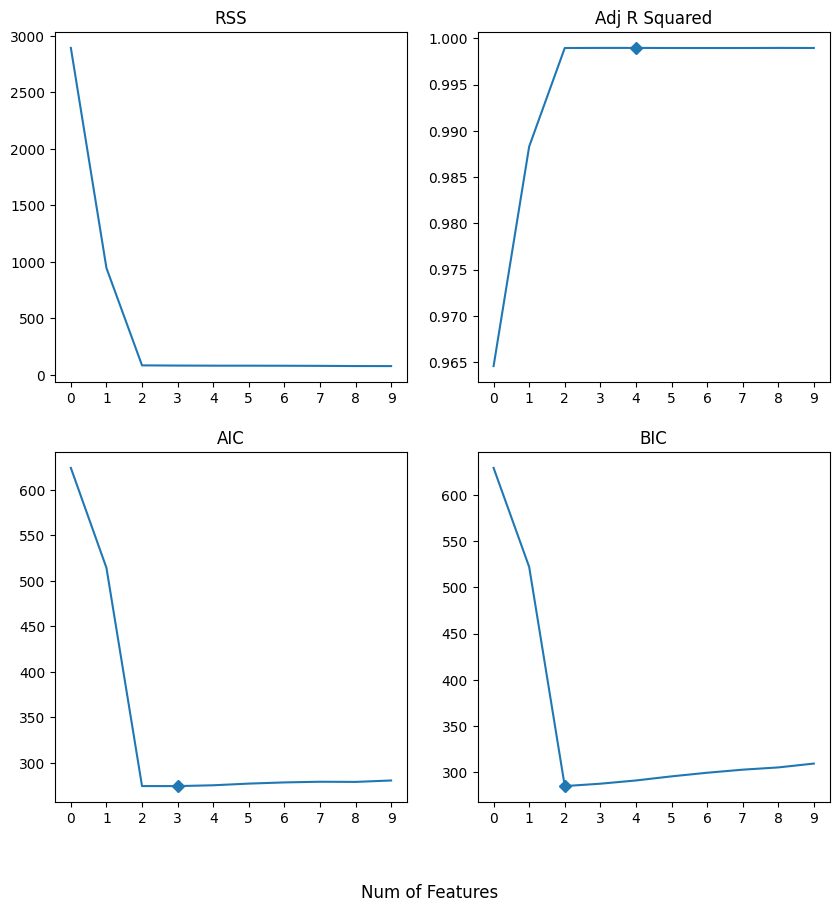

In [16]:
fig, axes = plt.subplots(2, 2, sharex=False, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.supxlabel('Num of Features')

axes[0, 0].plot(rss_fwd)
axes[0, 0].set_title('RSS')
axes[0, 0].set_xticks(np.arange(0, 10, 1))

axes[0, 1].plot(r2_adj_fwd, markevery=[np.argmax(r2_adj_fwd)], marker='D')
axes[0, 1].set_title('Adj R Squared')
axes[0, 1].set_xticks(np.arange(0, 10, 1))

axes[1, 0].plot(aic_fwd, markevery=[np.argmin(aic_fwd)], marker='D')
axes[1, 0].set_title('AIC')
axes[1, 0].set_xticks(np.arange(0, 10, 1))

axes[1, 1].plot(bic_fwd, markevery=[np.argmin(bic_fwd)], marker='D')
axes[1, 1].set_title('BIC')
axes[1, 1].set_xticks(np.arange(0, 10, 1))

In [17]:
print('5-variable model parameter acc.t. forward stepwise: ', bestsub_forward[4][0])
print('10-variable model parameter acc.t. forward stepwise: ', bestsub_forward[9][0])

5-variable model parameter acc.t. forward stepwise:  ['x3', 'x1', 'x2', 'x10', 'x5']
10-variable model parameter acc.t. forward stepwise:  ['x3', 'x1', 'x2', 'x10', 'x5', 'x9', 'x4', 'x8', 'x6', 'x7']


## Backward stepwise selection

In [18]:
def backward_stepwise(X, y, min_feature):
    models = []
    feature_list = list(X.columns)
    
    def update_model(feature_list):
        best_rss = np.inf
        best_model = None
        best_feature_list = []
        
        for feature in tqdm(feature_list):
            new_feature_list = [x for x in feature_list if x != feature]
            
            result = process_linear_model(new_feature_list, X, y)
            if result[1] < best_rss:
                best_rss = result[1]
                best_model = result[0]
        
        best_feature_list = list(best_model.params.index)[1:]
        return best_feature_list, best_model
    
    while len(feature_list) >= min_feature:
        best_feature_list, best_model = update_model(feature_list)
        feature_list = best_feature_list
        models.append([feature_list, best_model])
    
    return models

In [19]:
bestsub_backward = backward_stepwise(X, y, 1)

100%|██████████| 1/1 [00:00<00:00, 334.10it/s]


In [20]:
aic_back = [model[1].aic for model in bestsub_backward]
bic_back = [model[1].bic for model in bestsub_backward] 
r2_adj_back = [model[1].rsquared_adj for model in bestsub_backward]
rss_back = [model[1].ssr for model in bestsub_backward]

In [21]:
bestsub_backward

[[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x10'],
 [['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x8', 'x10'],
 [['x1', 'x2', 'x3', 'x4', 'x6', 'x8', 'x10'],
 [['x1', 'x2', 'x3', 'x6', 'x8', 'x10'],
 [['x1', 'x2', 'x3', 'x8', 'x10'],
 [['x1', 'x2', 'x3', 'x10'],
 [['x1', 'x2', 'x3'],
 [['x1', 'x3'],
 [['x3'],
 [[],

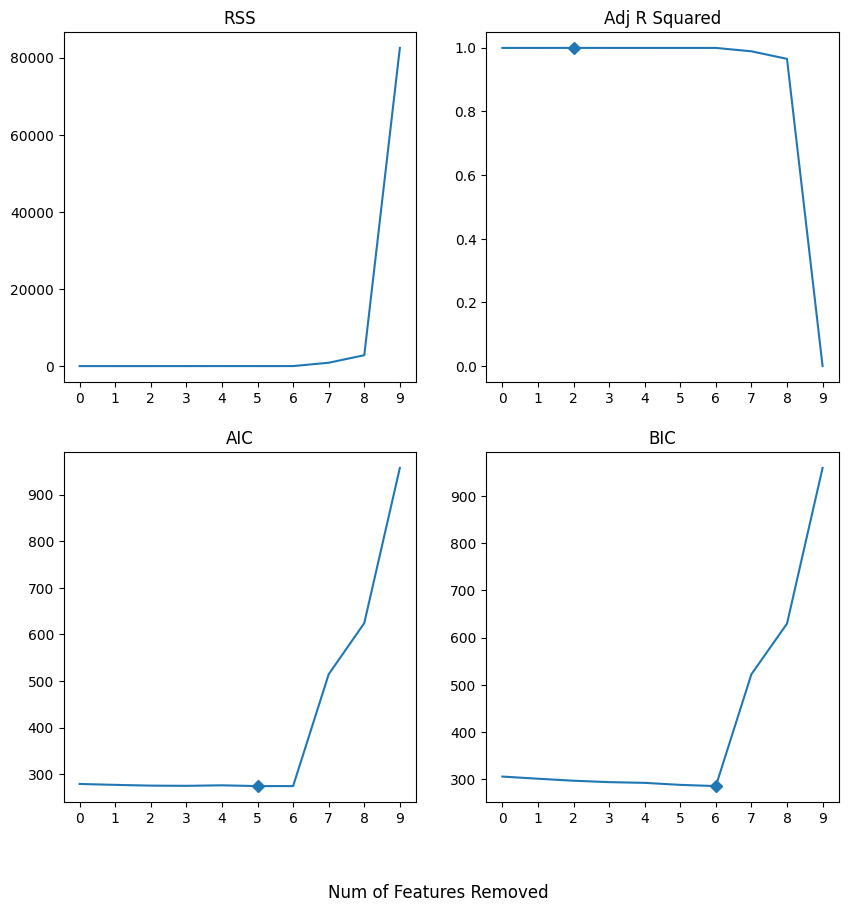

In [22]:
fig, axes = plt.subplots(2, 2, sharex=False, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.supxlabel('Num of Features Removed')

axes[0, 0].plot(rss_back)
axes[0, 0].set_title('RSS')
axes[0, 0].set_xticks(np.arange(0, 10, 1))

axes[0, 1].plot(r2_adj_back, markevery=[np.argmax(r2_adj_back)], marker='D')
axes[0, 1].set_title('Adj R Squared')
axes[0, 1].set_xticks(np.arange(0, 10, 1))

axes[1, 0].plot(aic_back, markevery=[np.argmin(aic_back)], marker='D')
axes[1, 0].set_title('AIC')
axes[1, 0].set_xticks(np.arange(0, 10, 1))

axes[1, 1].plot(bic_back, markevery=[np.argmin(bic_back)], marker='D')
axes[1, 1].set_title('BIC')
axes[1, 1].set_xticks(np.arange(0, 10, 1))

As shown above, we can say that subset selection results may differ depending on the algorithm used.

## Lasso

In [23]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import scale

alphas = np.logspace(-4, -1, 100)
lassocv = LassoCV(alphas=alphas, cv=5, max_iter=100000)

lassocv.fit(scale(X), y)

LassoCV(alphas=array([0.0001    , 0.00010723, 0.00011498, 0.00012328, 0.00013219,
       0.00014175, 0.00015199, 0.00016298, 0.00017475, 0.00018738,
       0.00020092, 0.00021544, 0.00023101, 0.00024771, 0.00026561,
       0.0002848 , 0.00030539, 0.00032745, 0.00035112, 0.00037649,
       0.0004037 , 0.00043288, 0.00046416, 0.0004977 , 0.00053367,
       0.00057224, 0.00061359, 0.00065793, 0.00070548, 0.00075646,
       0.000...
       0.00932603, 0.01      , 0.01072267, 0.01149757, 0.01232847,
       0.01321941, 0.01417474, 0.01519911, 0.01629751, 0.01747528,
       0.01873817, 0.02009233, 0.02154435, 0.0231013 , 0.02477076,
       0.02656088, 0.02848036, 0.03053856, 0.03274549, 0.03511192,
       0.03764936, 0.04037017, 0.04328761, 0.04641589, 0.04977024,
       0.05336699, 0.05722368, 0.06135907, 0.06579332, 0.07054802,
       0.07564633, 0.08111308, 0.0869749 , 0.09326033, 0.1       ]),
        cv=5, max_iter=100000)

In [24]:
lassocv.alpha_

0.0024770763559917113

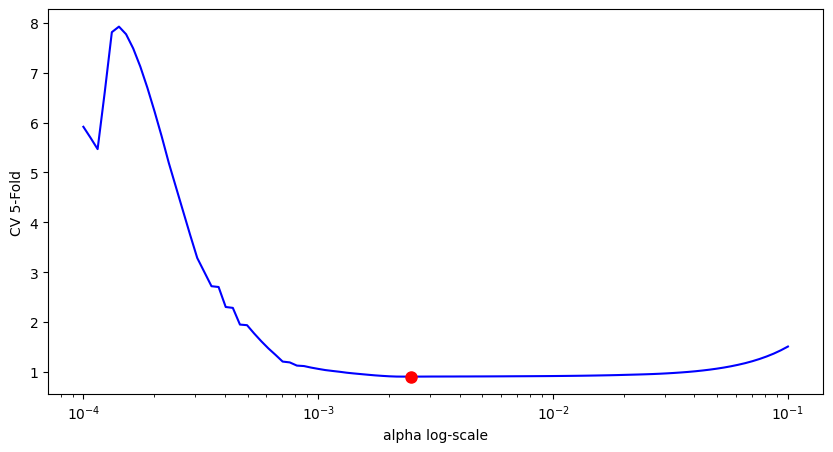

In [25]:
mses = np.mean(lassocv.mse_path_, axis=1)

# Plot CV error vs alpha
fig, ax = plt.subplots(figsize=(10,5));
ax.plot(lassocv.alphas_,mses, color='b');
ax.plot(lassocv.alpha_, np.min(mses), marker='o', color='r', markersize=8);
ax.set_xlabel('alpha log-scale');
ax.set_xscale('log')
ax.set_ylabel('CV 5-Fold');

In [26]:
pd.Series(lassocv.coef_.flatten(), index=X.columns)

x1     -9.058404
x2      3.707678
x3     37.697635
x4      0.000000
x5     -0.523257
x6      0.000000
x7     -0.000000
x8     -0.074017
x9      0.202386
x10    -0.214565
dtype: float64

In [27]:
y2 = -4 + 7.25 * (x**7) + eps

In [28]:
bestsub2 = find_best_subset(X, y2, 10, 'poly_bestsub_2')
bestsub2

100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


,sub,model
0,[x7],<statsmodels.regression.linear_model.Regressio...
1,"[x2, x7]",<statsmodels.regression.linear_model.Regressio...
2,"[x2, x7, x9]",<statsmodels.regression.linear_model.Regressio...
3,"[x2, x5, x7, x9]",<statsmodels.regression.linear_model.Regressio...
4,"[x4, x6, x7, x8, x10]",<statsmodels.regression.linear_model.Regressio...
5,"[x2, x4, x6, x7, x8, x10]",<statsmodels.regression.linear_model.Regressio...
6,"[x1, x3, x4, x6, x7, x8, x10]",<statsmodels.regression.linear_model.Regressio...
7,"[x1, x2, x3, x4, x6, x7, x8, x10]",<statsmodels.regression.linear_model.Regressio...
8,"[x1, x3, x4, x5, x6, x7, x8, x9, x10]",<statsmodels.regression.linear_model.Regressio...
9,"[x1, x2, x3, x4, x5, x6, x7, x8, x9, x10]",<statsmodels.regression.linear_model.Regressio...


In [29]:
aic2 = [bestsub2.model[i].aic for i in range(0, len(bestsub2.model))]
bic2 = [bestsub2.model[i].bic for i in range(0, len(bestsub2.model))]
r2_adj2 = [bestsub2.model[i].rsquared_adj for i in range(0, len(bestsub2.model))]
rss2 = [bestsub2.model[i].ssr for i in range(0, len(bestsub2.model))]

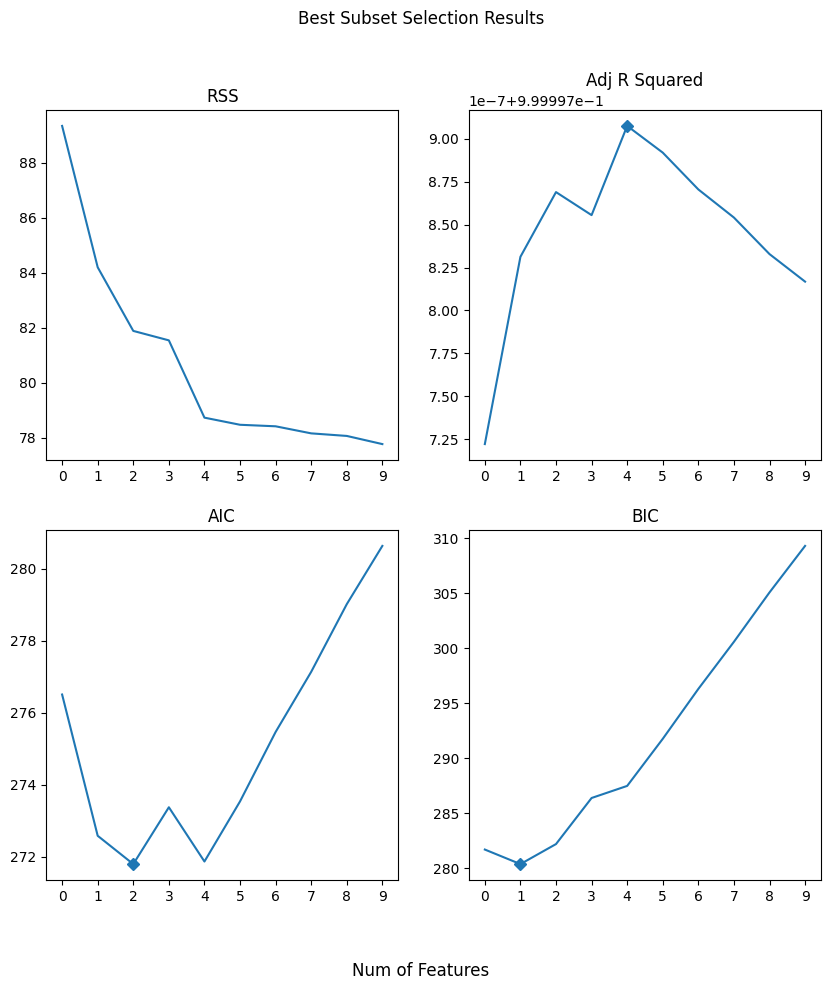

In [30]:
fig, axes = plt.subplots(2, 2, sharex=False, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.supxlabel('Num of Features')

fig.suptitle('Best Subset Selection Results')

axes[0, 0].plot(rss2)
axes[0, 0].set_title('RSS')
axes[0, 0].set_xticks(np.arange(0, 10, 1))

axes[0, 1].plot(r2_adj2, markevery=[np.argmax(r2_adj2)], marker='D')
axes[0, 1].set_title('Adj R Squared')
axes[0, 1].set_xticks(np.arange(0, 10, 1))

axes[1, 0].plot(aic2, markevery=[np.argmin(aic2)], marker='D')
axes[1, 0].set_title('AIC')
axes[1, 0].set_xticks(np.arange(0, 10, 1))

axes[1, 1].plot(bic2, markevery=[np.argmin(bic2)], marker='D')
axes[1, 1].set_title('BIC')
axes[1, 1].set_xticks(np.arange(0, 10, 1))

In [31]:
np.random.seed(5)
lassocv2 = LassoCV(n_alphas=400, cv=10, max_iter=10000)

lassocv2.fit(scale(X), y2.ravel())

LassoCV(cv=10, max_iter=10000, n_alphas=400)

In [32]:
# optimal value of alpha
lassocv2.alpha_

0.6294529432961685

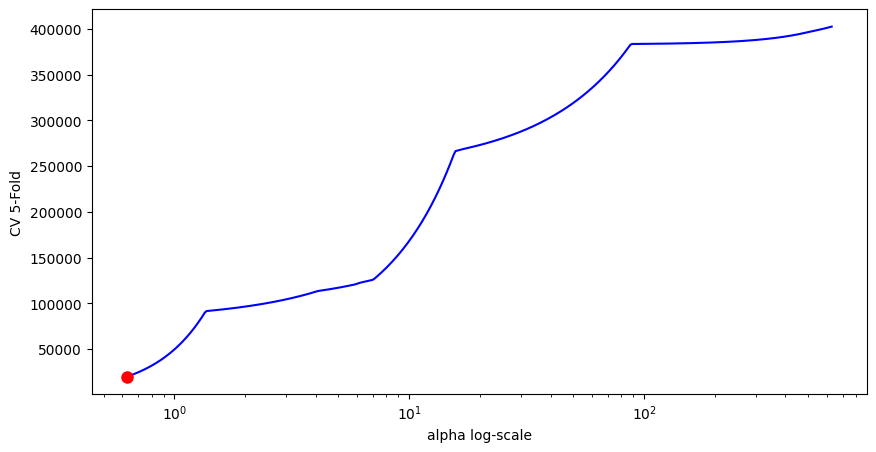

In [33]:
mses = np.mean(lassocv2.mse_path_, axis=1)

# Plot CV error vs alpha
fig, ax = plt.subplots(figsize=(10,5));
ax.plot(lassocv2.alphas_,mses, color='b');
ax.plot(lassocv2.alpha_, np.min(mses), marker='o', color='r', markersize=8);
ax.set_xlabel('alpha log-scale');
ax.set_xscale('log')
ax.set_ylabel('CV 5-Fold');

In [34]:
# Coefficient estimates of lasso model
pd.Series(lassocv2.coef_.flatten(), index=X.columns)

x1      -0.000000
x2      -0.000000
x3       0.000000
x4      -0.000000
x5      37.345740
x6      -2.373753
x7     519.204613
x8      -0.000000
x9      71.461751
x10     -0.000000
dtype: float64

As we can observe from the coefficient estimates, the lasso model includes only four noise variables (x5, x6,x7, x9).